# Interactions between ProTα and Histone H1.0 evolution variants

In [2]:
# Imports
import sys
import json
import pandas as pd
import os
import mdtraj as md
from matplotlib import pyplot as plt
import numpy as np

sys.path.append('../../src')
import data_utils
import analyse_utils
import simulate_utils

## Data preparation

### Topologies

#### Compact frames

In [11]:
# Loading trajectories
trajs = {}
resultsdir = "results/single_chain/default"
for variant in os.listdir(resultsdir):
    dir = f"{resultsdir}/{variant}"
    trajs[variant] = md.load_dcd(f"{dir}/traj.dcd", f"{dir}/top.pdb")

In [12]:
# Saving most compact frame as topology
for variant, traj in trajs.items():
    compact_frame = analyse_utils.compact_frame(traj)
    compact_frame.save_pdb(f'data/{variant}.pdb')

#### Merging

In [13]:
# Loading topologies
H10_vars = {}
ProTa = None
data_path = 'data'
for file in os.listdir(data_path):
    if '.pdb' in file:
        traj = md.load(f'{data_path}/{file}')

        id = file[:-4]
        if ('H1-0_VAR' in id) and ('PROTA_WT' not in id):
            H10_vars[id] = traj

        elif 'PROTA_WT' == id:
            ProTa = traj

print(H10_vars.keys())

dict_keys(['H1-0_VAR_k0.14', 'H1-0_VAR_k0.36', 'H1-0_VAR_k0.93', 'H1-0_VAR_k0.90', 'H1-0_VAR_k0.20', 'H1-0_VAR_k0.46', 'H1-0_VAR_k0.30', 'H1-0_VAR_k0.70', 'H1-0_VAR_k0.84', 'H1-0_VAR_k0.98', 'H1-0_VAR_k0.79', 'H1-0_VAR_k0.27', 'H1-0_VAR_k0.75', 'H1-0_VAR_k0.60', 'H1-0_VAR_k0.65', 'H1-0_VAR_k0.55', 'H1-0_VAR_k0.50', 'H1-0_VAR_k0.40', 'H1-0_VAR_k0.07', 'H1-0_VAR_k0.11'])


In [14]:
# Making sets of topologies
twochain_sets = [[H10_var, ProTa] for H10_var in H10_vars.values()]

In [15]:
# Translating topologies
for tc_set  in twochain_sets:
    translate_x = 10 # nm
    translate_y = 0 # nm
    translate_z = 0 # nm
    for i, traj in enumerate(tc_set):
        traj.center_coordinates()
        traj.xyz += [translate_x*i, translate_y*i, translate_z*i]

In [16]:
# Merging topologies
boxlength = 25 # nm
tc_merges = [simulate_utils.merge_topologies(tc_set, boxlength=boxlength) for tc_set in twochain_sets]
for traj in tc_merges:
    traj.center_coordinates()
    traj.xyz += traj.unitcell_lengths[0,0]/2

In [17]:
# Saving merged topologies
for traj, H10_var_id in zip(tc_merges, H10_vars.keys()):
    filename = f'data/{H10_var_id}_PROTA_WT_{boxlength}nm.pdb'
    traj.save(filename)

## Analysis

### Single chain

In [32]:
# Loading trajectories
traj = {}
resultsdir = "results/single_chain/default"
for variant in os.listdir(resultsdir):
    dir = f"{resultsdir}/{variant}"
    traj[variant] = md.load_dcd(f"{dir}/traj.dcd", f"{dir}/top.pdb")

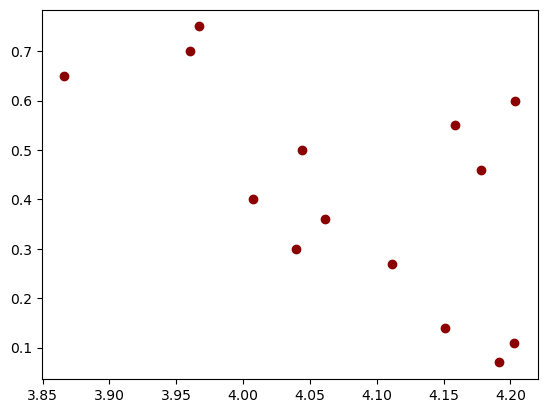

In [14]:
# Checking Rg kappa range
kappas = [float(var[-4:]) for var in traj]
rgs = [analyse_utils.compute_rg(t) for t in traj.values()]
mean_rgs = [rg.mean() for rg in rgs]
data = pd.DataFrame({'kappa': kappas, 'Rg': rgs, '<Rg>': mean_rgs}, index=traj.keys())

plt.scatter(data['<Rg>'], data['kappa'], color='darkred')

In [18]:
# Loading evolution data files
minevo_1 = pd.read_pickle('../idpevo_h1-0/results/francesco_algorithm/0_1/evolution.pkl')
minevo_2 = pd.read_pickle('../idpevo_h1-0/results/francesco_algorithm/0_2/evolution.pkl')
minevo_3 = pd.read_pickle('../idpevo_h1-0/results/francesco_algorithm/0_3/evolution.pkl')
minevo_4 = pd.read_pickle('../idpevo_h1-0/results/francesco_algorithm/0_4/evolution.pkl')
maxevo = pd.read_pickle(  '../idpevo_h1-0/results/francesco_algorithm/10/evolution.pkl')
consevo = pd.read_pickle( '../idpevo_h1-0/results/francesco_algorithm/4.258203/evolution.pkl')
allevo = pd.concat([minevo_1, minevo_2, minevo_3, minevo_4, maxevo, consevo])

In [23]:
# Getting evo data
evo_rg = allevo[allevo.simulate]['obs'].astype(float)
evo_kappa = allevo[allevo.simulate].apply(lambda row: analyse_utils.SequenceParameters(''.join(row.fasta)).get_kappa(), axis=1)

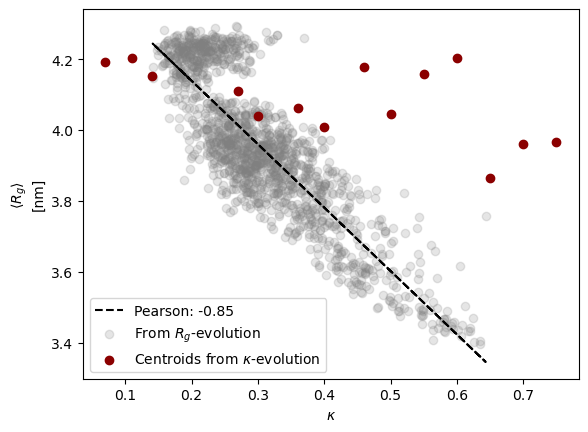

In [31]:
# Comparing Kappa evolution as a guide for Rg evolution
from scipy.stats import pearsonr

x = evo_kappa
y = evo_rg
corr, p_value = pearsonr(x, y)
slope, intercept = np.polyfit(x, y, 1)
plt.plot(x, x*slope+intercept, color='k', linestyle='--')

plt.scatter(x, y, alpha=0.2, color='grey')
plt.scatter(data['kappa'], data['<Rg>'], color='darkred')

plt.xlabel("$\kappa$")
plt.ylabel("$\left\langle R_g \\right\\rangle$\n[nm]")
plt.legend([f"Pearson: {corr:.2f}", "From $R_g$-evolution", "Centroids from $\kappa$-evolution"])
plt.show()


### Two chain

#### $K_d$

In [10]:
# Loading precalculated energy data
datas = []
resultsdir = "results/two_chain/ionic_240"
for variant in os.listdir(resultsdir):
    dir = f"{resultsdir}/{variant}"
    data = pd.read_csv(dir+'/interaction_energy.csv', index_col=0).sort_index()
    data['Total energy [kJ/mol]'] = data['Ashbaugh-Hatch [kJ/mol]'] + data['Debye-Hückel [kJ/mol]']
    data['kappa'] = float(variant[10:14])
    datas.append(data)
data = pd.concat(datas)
data

,Ashbaugh-Hatch [kJ/mol],Debye-Hückel [kJ/mol],Minimum interresidue distance [nm],Center of mass distance [nm],Total energy [kJ/mol],kappa
0,-0.741330,-25.786947,0.505691,3.984576,-26.528277,0.14
1,-3.622817,-18.265006,0.576970,3.196620,-21.887822,0.14
2,-1.100950,-16.902042,0.520501,2.460551,-18.002992,0.14
3,0.253064,-24.039139,0.517909,1.631929,-23.786075,0.14
4,0.184446,-13.692588,0.570105,1.410176,-13.508141,0.14
...,...,...,...,...,...,...
64995,-5.993646,32.719880,0.582855,1.471935,26.726234,0.98
64996,-1.521377,29.842139,0.558869,1.845459,28.320761,0.98
64997,-0.491038,44.654605,0.506710,1.891271,44.163567,0.98
64998,-12.850232,11.358158,0.539729,2.360060,-1.492073,0.98


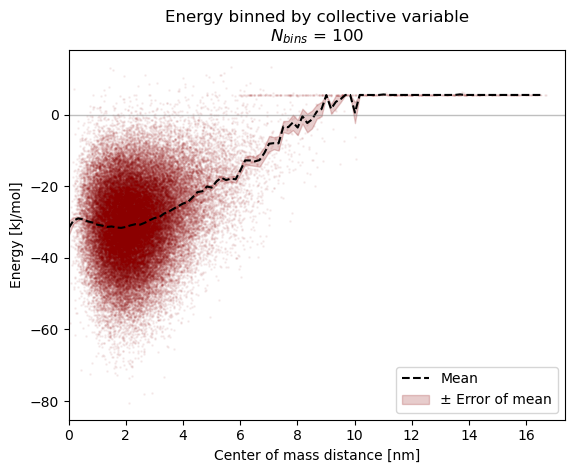

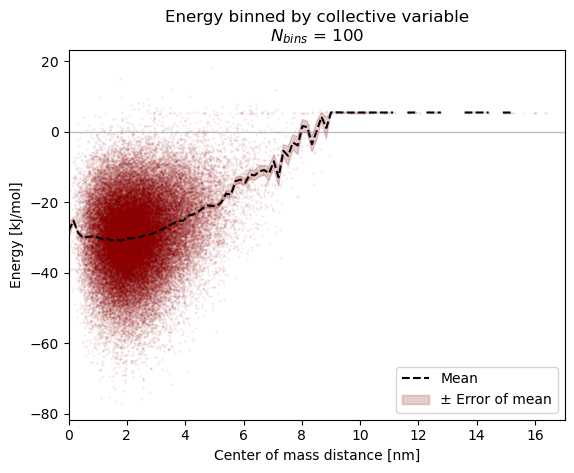

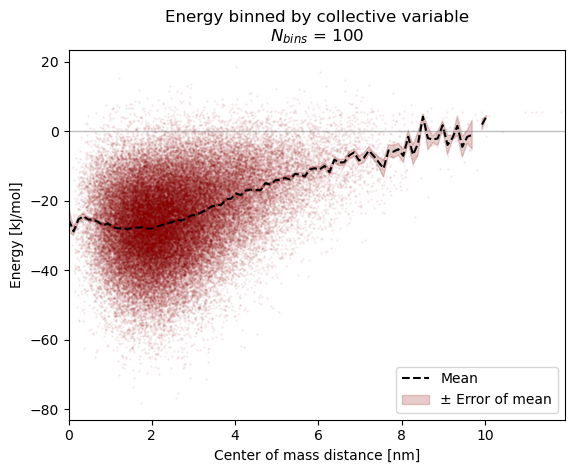

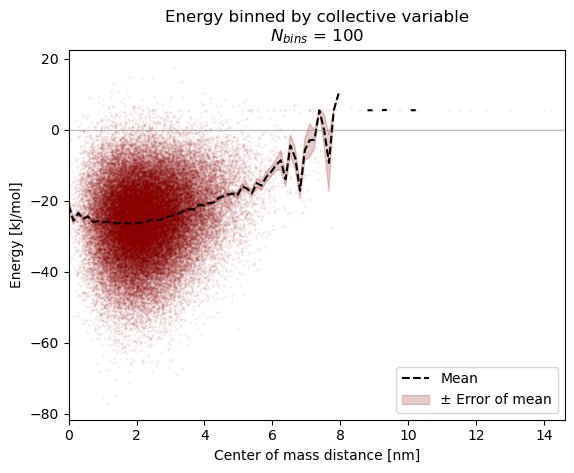

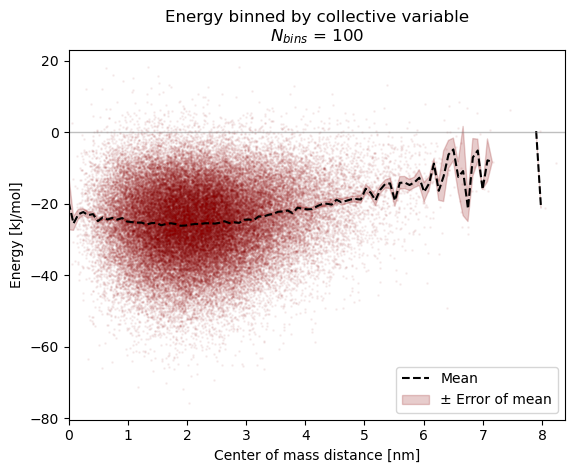

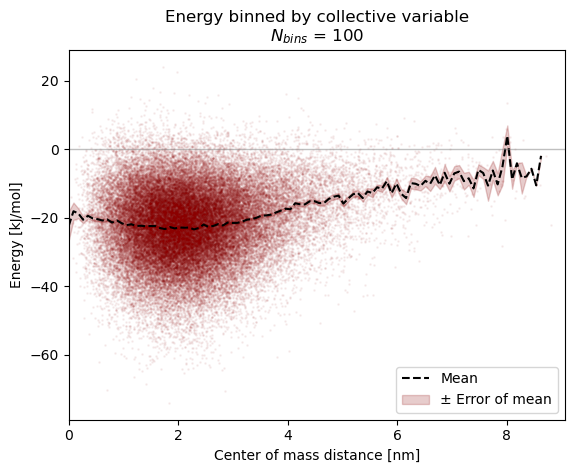

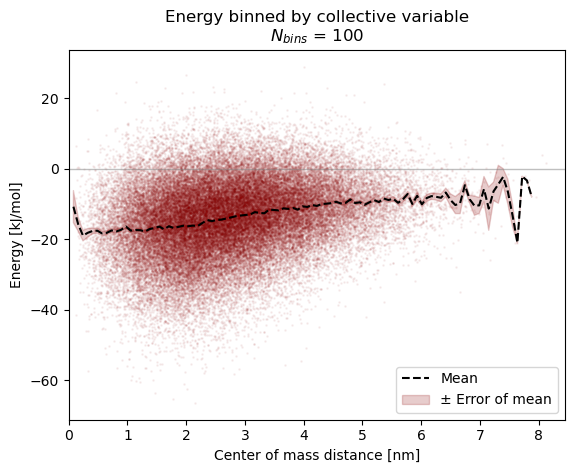

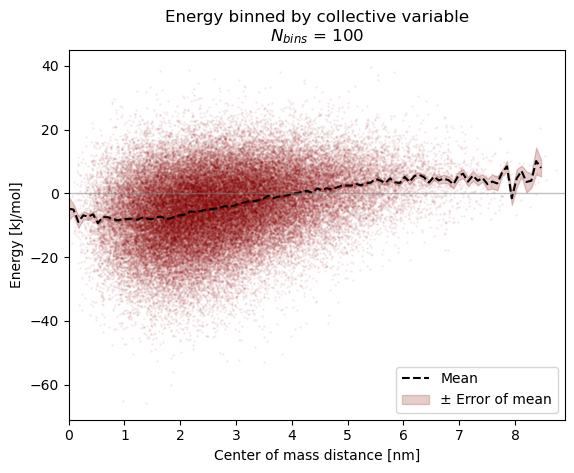

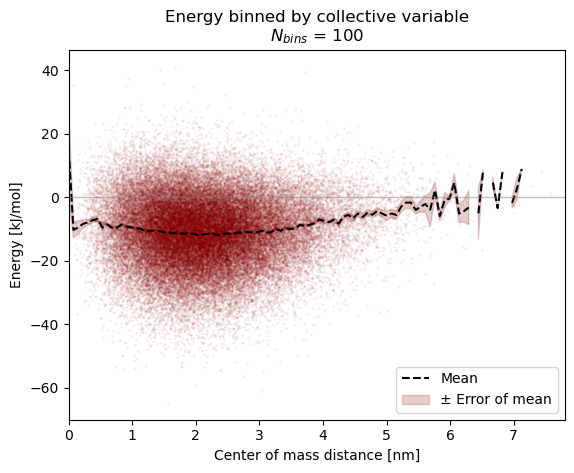

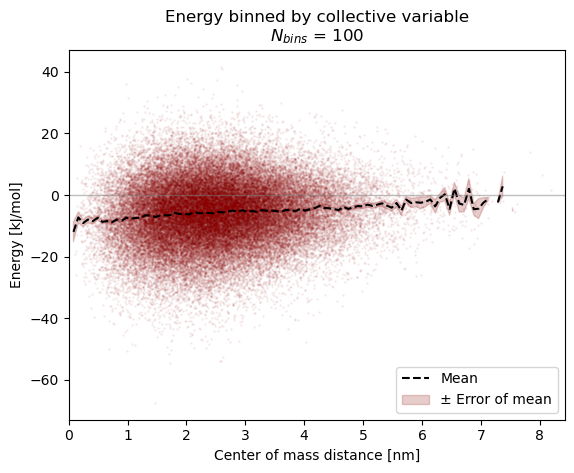

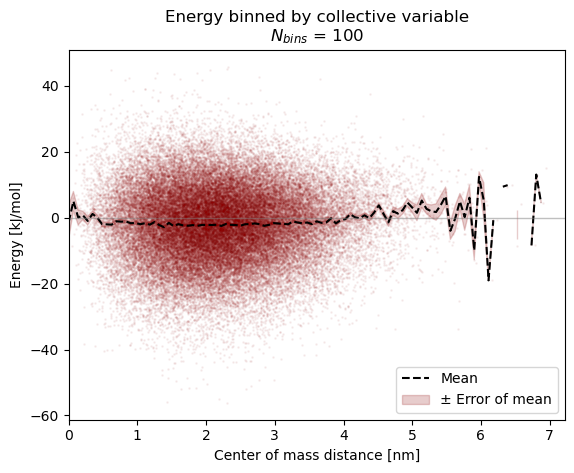

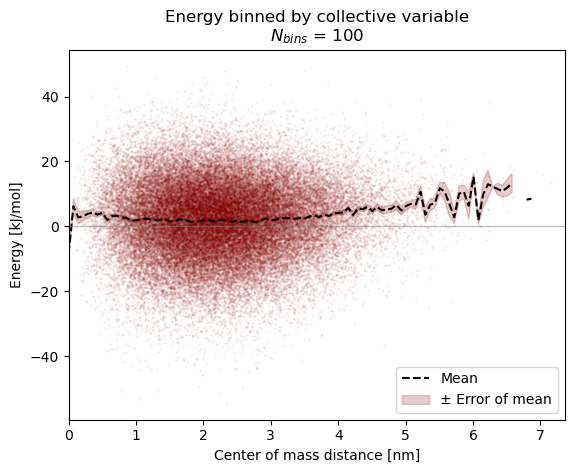

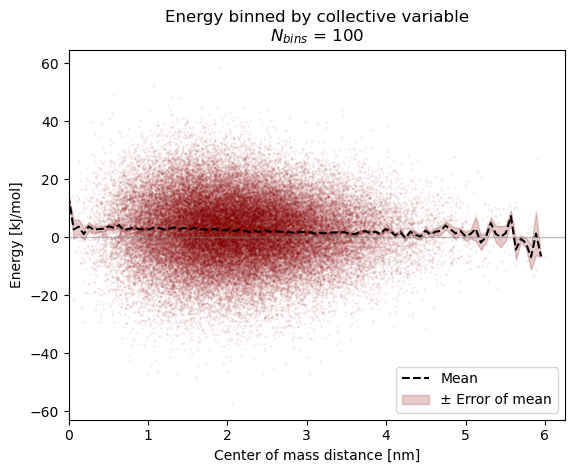

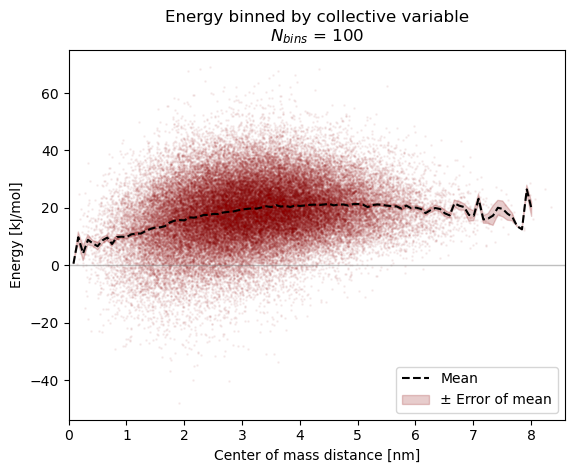

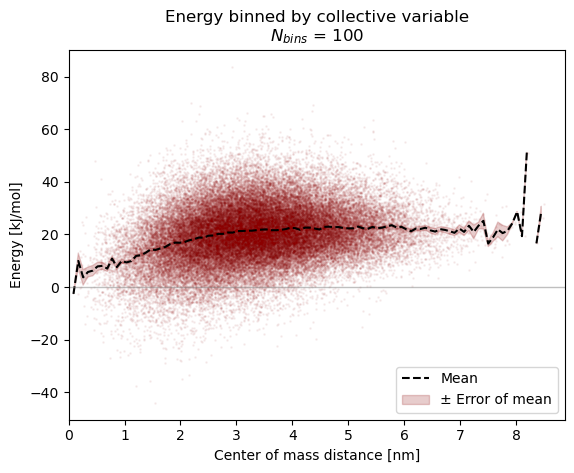

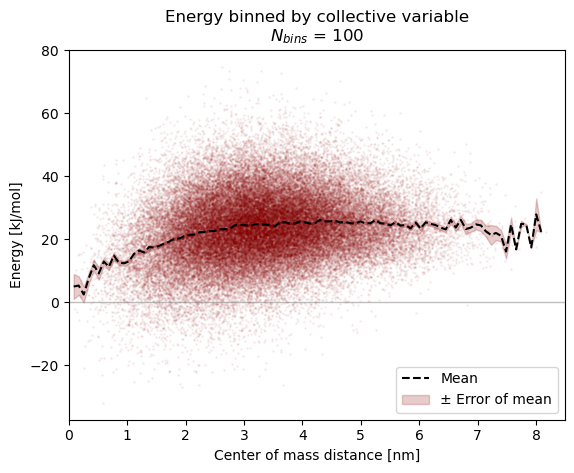

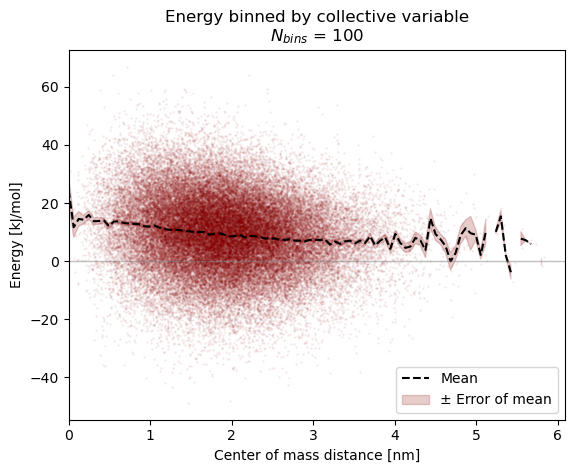

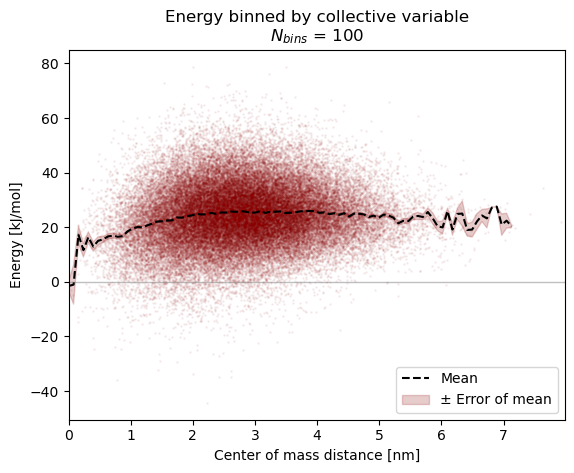

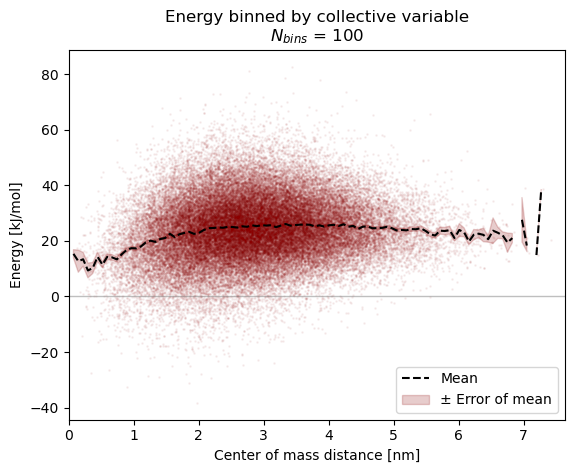

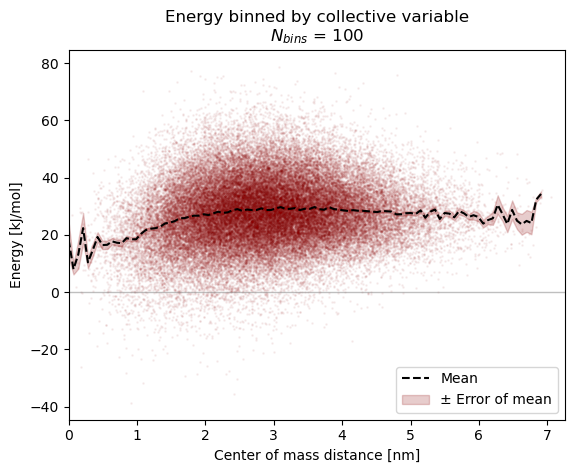

In [16]:
Kds = data.groupby('kappa').apply(lambda df: analyse_utils.compute_Kd(df['Total energy [kJ/mol]'], df['Center of mass distance [nm]'], 298, 100))

Text(0, 0.5, '$log_{10}(K_d)$')

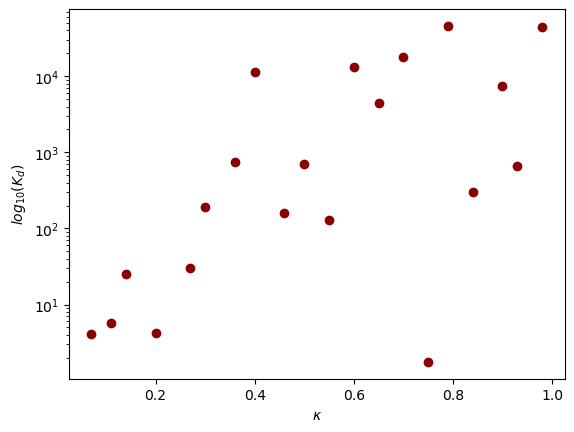

In [32]:
plt.scatter(Kds.index, Kds, color='darkred')
plt.yscale('log')
plt.xlabel('$\kappa$')
plt.ylabel('$log_{10}(K_d)$')

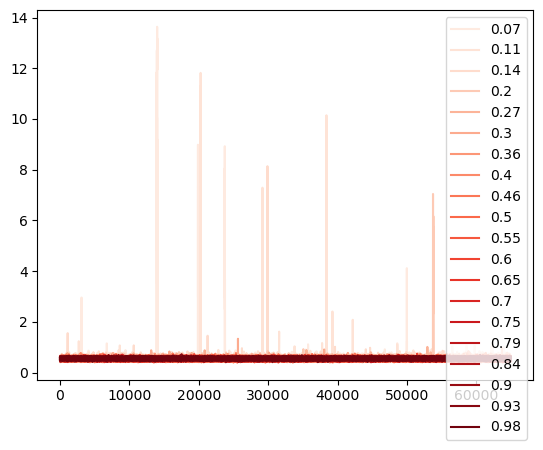

In [30]:
cmap = plt.cm.Reds
data.groupby('kappa').apply(lambda df: plt.plot(df['Minimum interresidue distance [nm]'], label=round(df['kappa'].min(),2), color=cmap(df['kappa'].min())))
plt.legend(loc='upper right')